<a href="https://colab.research.google.com/github/dsklnr/Loan_Prediction/blob/Ben_Ogle_Branch/LoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
import scipy.stats as stats

from google.colab import drive
from google.colab import files

In [2]:
# Format the Jupyter notebook output to show all columns and rows
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# Allowing google colab to access drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Uploading dataset
uploaded = files.upload()

Saving loan_approval_dataset.csv to loan_approval_dataset.csv


## **Data Preprocessing**

## Import the dataset and check for null values

In [5]:
# Read the csv file
loan = pd.read_csv("/content/loan_approval_dataset.csv")
loan_df = pd.DataFrame(loan)
loan_df

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,1000000,2300000,12,317,2800000,500000,3300000,800000,Rejected
4265,4266,0,Not Graduate,Yes,3300000,11300000,20,559,4200000,2900000,11000000,1900000,Approved
4266,4267,2,Not Graduate,No,6500000,23900000,18,457,1200000,12400000,18100000,7300000,Rejected
4267,4268,1,Not Graduate,No,4100000,12800000,8,780,8200000,700000,14100000,5800000,Approved


In [6]:
# Get the number of rows and columns
loan_df.shape

(4269, 13)

In [7]:
# remove the space infront of each columns name
loan_df = loan_df.rename(columns = {' no_of_dependents' : 'no_of_dependents'})
loan_df = loan_df.rename(columns = {' education' : 'education'})
loan_df = loan_df.rename(columns = {' self_employed' : 'self_employed'})
loan_df = loan_df.rename(columns = {' income_annum' : 'income_annum'})
loan_df = loan_df.rename(columns = {' loan_amount' : 'loan_amount'})
loan_df = loan_df.rename(columns = {' loan_term' : 'loan_term'})
loan_df = loan_df.rename(columns = {' cibil_score' : 'cibil_score'})
loan_df = loan_df.rename(columns = {' residential_assets_value' : 'residential_assets_value'})
loan_df = loan_df.rename(columns = {' commercial_assets_value' : 'commercial_assets_value'})
loan_df = loan_df.rename(columns = {' luxury_assets_value' : 'luxury_assets_value'})
loan_df = loan_df.rename(columns = {' bank_asset_value' : 'bank_asset_value'})
loan_df = loan_df.rename(columns = {' loan_status' : 'loan_status'})

In [8]:
# Get all the data types
loan_df.dtypes

loan_id                      int64
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

In [9]:
# Get the total number of non null values for each column
non_nulls = loan_df.count()

# Sort the number of nun null values for each column from greatest to least
non_nulls.sort_values(ascending=False)

loan_id                     4269
no_of_dependents            4269
education                   4269
self_employed               4269
income_annum                4269
loan_amount                 4269
loan_term                   4269
cibil_score                 4269
residential_assets_value    4269
commercial_assets_value     4269
luxury_assets_value         4269
bank_asset_value            4269
loan_status                 4269
dtype: int64

In [10]:
# Get the total number of null values for each column
total_nulls = loan_df.isnull().sum()

# Sort the number of null values for each column in decsending order
total_nulls.sort_values(ascending=False)

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

## Ensure each column's values are valid. If they are not, clean them.

In [11]:
# Get all number of dependent values and the count for each level
num_of_dependents = loan_df['no_of_dependents'].value_counts()

# Sort the count of dependents in ascending order
num_of_dependents.sort_index(ascending=True)

0    712
1    697
2    708
3    727
4    752
5    673
Name: no_of_dependents, dtype: int64

In [12]:
# Get all education values and the count for each
num_of_dependents = loan_df['education'].value_counts()

# Sort the count of education types in decsending order
num_of_dependents.sort_values(ascending=False)

 Graduate        2144
 Not Graduate    2125
Name: education, dtype: int64

In [13]:
# Get self employment status and the count for each
num_of_dependents = loan_df['self_employed'].value_counts()

# Sort the count of self employed in decsending order
num_of_dependents.sort_index(ascending=False)

 Yes    2150
 No     2119
Name: self_employed, dtype: int64

In [14]:
# Get all annual income values and the count for each
num_of_dependents = loan_df['income_annum'].value_counts()

# Sort annual incomes in decsending order
num_of_dependents.sort_index(ascending=False)

9900000    35
9800000    48
9700000    40
9600000    39
9500000    40
9400000    47
9300000    33
9200000    49
9100000    40
9000000    53
8900000    41
8800000    49
8700000    40
8600000    40
8500000    32
8400000    52
8300000    46
8200000    41
8100000    40
8000000    53
7900000    45
7800000    49
7700000    38
7600000    57
7500000    45
7400000    44
7300000    33
7200000    35
7100000    45
7000000    62
6900000    55
6800000    44
6700000    30
6600000    46
6500000    43
6400000    45
6300000    41
6200000    37
6100000    42
6000000    41
5900000    42
5800000    46
5700000    41
5600000    47
5500000    41
5400000    45
5300000    55
5200000    46
5100000    47
5000000    41
4900000    46
4800000    37
4700000    56
4600000    42
4500000    39
4400000    48
4300000    43
4200000    39
4100000    59
4000000    36
3900000    54
3800000    52
3700000    41
3600000    33
3500000    47
3400000    33
3300000    46
3200000    55
3100000    43
3000000    35
2900000    50
280000

In [15]:
# Get all loan amounts and the count for each
num_of_dependents = loan_df['loan_amount'].value_counts()

# Sort loan amounts types in decsending order
num_of_dependents.sort_index(ascending=False)

39500000     1
38800000     1
38700000     2
38500000     1
38400000     1
38200000     3
38000000     1
37900000     2
37800000     2
37700000     1
37600000     2
37500000     1
37300000     3
37000000     2
36800000     3
36700000     2
36600000     1
36500000     2
36400000     3
36300000     1
36100000     1
36000000     2
35900000     3
35800000     1
35700000     3
35500000     4
35400000     3
35300000     3
35200000     3
35100000     2
35000000     4
34900000     4
34800000     3
34700000     1
34600000     2
34500000     3
34400000     1
34300000     3
34200000     5
34100000     4
34000000     7
33900000     3
33800000     1
33700000     3
33600000     4
33500000     4
33400000     1
33300000     4
33200000     3
33100000     2
33000000     5
32900000     4
32800000     1
32700000     2
32600000     5
32500000     3
32400000     5
32300000     2
32200000     4
32100000     6
32000000     4
31900000     4
31800000     6
31700000     3
31600000     2
31500000    11
31400000  

In [16]:
# Get all loan terms and the count for each
num_of_dependents = loan_df['loan_term'].value_counts()

# Sort the count of each loan term in decsending order
num_of_dependents.sort_values(ascending=False)

6     490
12    456
4     447
10    436
18    422
16    412
20    411
14    405
2     404
8     386
Name: loan_term, dtype: int64

In [17]:
# Get all cibil scores and the count for each
num_of_dependents = loan_df['cibil_score'].value_counts()

# Sort the count of each cibil score in decsending order
num_of_dependents.sort_values(ascending=False)

348    16
538    15
543    15
778    14
509    14
       ..
334     2
773     2
893     2
484     2
864     1
Name: cibil_score, Length: 601, dtype: int64

In [18]:
# Get all residential asset values and the count for each
num_of_dependents = loan_df['residential_assets_value'].value_counts()

# Sort the count of residential asset values in decsending order
num_of_dependents.sort_values(ascending=False)

 400000      66
 500000      63
 100000      60
 1000000     57
 600000      56
 1300000     55
 700000      52
 300000      52
 3200000     50
 200000      50
 900000      48
 800000      45
 0           45
 1400000     43
 2200000     43
 1200000     42
 1600000     42
 3600000     41
 1900000     41
 1700000     40
 2400000     40
 1500000     40
 1100000     38
 4700000     38
 3800000     37
 2000000     36
 2300000     35
 3400000     34
 2900000     33
 2500000     32
 4200000     32
 3500000     32
 2800000     32
 3300000     31
 3000000     31
 2100000     31
 4100000     31
 1800000     31
 3900000     30
 3700000     30
 5100000     30
 2700000     30
 4900000     29
 5800000     29
 5300000     29
 6800000     29
 2600000     29
 3100000     28
-100000      28
 6400000     28
 4000000     28
 4400000     28
 5900000     28
 6300000     27
 4300000     27
 6100000     27
 7800000     27
 6700000     27
 4500000     26
 8800000     26
 4800000     26
 5000000     25
 4600000

In [19]:
# Get all commercial asset values and the count for each
num_of_dependents = loan_df['commercial_assets_value'].value_counts()

# Sort the count of commercial assets values in decsending order
num_of_dependents.sort_values(ascending=False)

0           107
200000      101
100000      100
300000       90
500000       83
800000       76
700000       74
400000       71
600000       70
1000000      67
2200000      63
1200000      63
1300000      62
2900000      60
1100000      59
2400000      56
1500000      53
1400000      52
900000       52
1800000      52
1900000      50
1600000      49
2000000      46
4000000      46
2700000      46
3700000      46
2100000      45
1700000      45
2500000      43
2600000      43
2800000      42
2300000      42
3100000      41
3500000      41
3300000      40
3400000      38
4200000      37
5100000      37
3900000      37
3800000      35
4300000      34
4500000      34
5600000      32
3000000      32
4600000      31
4800000      31
5000000      31
6100000      30
3600000      30
5200000      29
6000000      28
4700000      28
5900000      27
5300000      27
4900000      27
5500000      27
4100000      27
6600000      26
7300000      26
5700000      26
7900000      25
6400000      25
9300000 

In [20]:
# Get all luxury asset values and the count for each
num_of_dependents = loan_df['luxury_assets_value'].value_counts()

# Sort the count of luxury asset values in decsending order
num_of_dependents.sort_values(ascending=False)

6200000     26
20400000    26
2900000     26
12300000    24
14900000    24
12000000    24
7100000     23
17200000    23
14100000    22
9900000     22
13900000    22
20700000    22
19300000    21
16400000    21
12600000    21
2200000     21
6700000     20
20000000    20
10900000    20
17100000    20
8600000     20
3700000     20
7700000     20
15600000    20
1100000     19
18800000    19
20200000    19
7300000     19
11700000    19
2100000     19
19500000    19
2000000     19
13000000    19
5400000     19
16500000    19
15100000    19
6100000     19
12200000    19
8100000     18
4300000     18
14300000    18
1900000     18
4600000     18
1800000     18
5200000     18
3500000     18
17700000    18
18500000    18
4800000     18
2300000     18
21700000    17
11600000    17
5600000     17
16700000    17
21800000    17
14600000    17
16300000    17
19900000    17
6000000     17
8200000     17
7200000     17
17300000    17
7500000     17
10300000    17
22400000    17
3200000     17
11400000  

In [21]:
# Get all bank asset values and the count for each
num_of_dependents = loan_df['bank_asset_value'].value_counts()

# Sort the count of bank asset values in decsending order
num_of_dependents.sort_values(ascending=False)

1400000     63
3600000     63
4900000     63
4500000     61
1600000     60
5400000     59
900000      58
1300000     57
1500000     54
3400000     54
200000      54
4100000     54
2400000     54
3300000     53
5500000     52
2000000     52
4800000     52
4200000     51
2900000     51
400000      50
600000      50
300000      50
3100000     50
4700000     50
2700000     49
3000000     49
2100000     48
5300000     48
3900000     48
2800000     47
2600000     47
5800000     47
4300000     47
4000000     46
3500000     46
1700000     46
7200000     46
6100000     45
6600000     44
5700000     44
1100000     43
5200000     43
4400000     42
700000      42
3200000     41
6000000     41
5600000     41
5900000     41
3800000     41
1900000     41
500000      40
2300000     40
800000      39
7000000     39
6800000     38
6200000     38
4600000     37
2200000     37
3700000     37
1800000     36
6700000     36
1200000     36
6400000     36
5000000     35
5100000     34
7500000     34
6300000   

In [22]:
# Get all loan statuses and the count for each
num_of_dependents = loan_df['loan_status'].value_counts()

# Sort the count of loan statuses in decsending order
num_of_dependents.sort_values(ascending=False)

 Approved    2656
 Rejected    1613
Name: loan_status, dtype: int64

## Remove Outliers from Columns

In [23]:
loan_df.shape

(4269, 13)

In [24]:
# Create a function to remove outliers from one column in a dataframe based on iqr
def remove_outliers(column, dataframe):
  quartile1 = dataframe[column].quantile(0.25)
  quartile3 = dataframe[column].quantile(0.75)
  iqr = quartile3 - quartile1
  lower_bound = quartile1 - 1.5 * iqr
  upper_bound = quartile3 + 1.5 * iqr
  removed_outliers_df = dataframe[(dataframe[column] >= lower_bound)
          & (dataframe[column] <= upper_bound)]
  print(dataframe.shape)
  return removed_outliers_df

In [25]:
# Remove outliers from annual incomes
loan_df = remove_outliers("income_annum", loan_df)

(4269, 13)


In [26]:
# Remove outliers from loan amounts
loan_df = remove_outliers("loan_amount", loan_df)

(4269, 13)


In [27]:
# Remove outliers from cibil scores
loan_df = remove_outliers("cibil_score", loan_df)

(4269, 13)


In [28]:
# Remove outliers from residential asset values
loan_df = remove_outliers("residential_assets_value", loan_df)

(4269, 13)


In [29]:
# Remove outliers from commercial asset values
loan_df = remove_outliers("commercial_assets_value", loan_df)

(4217, 13)


In [30]:
# Remove outliers from luxury asset values
loan_df = remove_outliers("luxury_assets_value", loan_df)

(4182, 13)


In [31]:
# Remove outliers from bank asset values
loan_df = remove_outliers("bank_asset_value", loan_df)

(4182, 13)


## **Exploratory Data Analysis**

## Visualize the Data

Number of Dependents



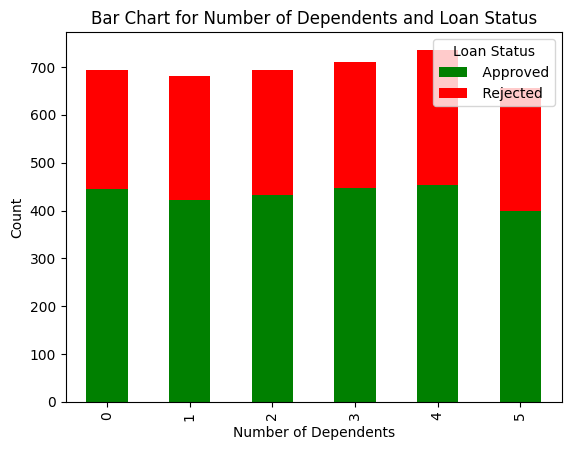

In [32]:
# Create a crosstab for number of dependents and loan status
dependent_crosstab = pd.crosstab(loan_df["no_of_dependents"], loan_df["loan_status"])

# Display the bar chart
dependent_crosstab.plot(kind = "bar", stacked = True, color = ["green", "red"])
plt.legend(title = "Loan Status")
plt.title("Bar Chart for Number of Dependents and Loan Status")
plt.xlabel("Number of Dependents")
plt.ylabel("Count")
plt.show()

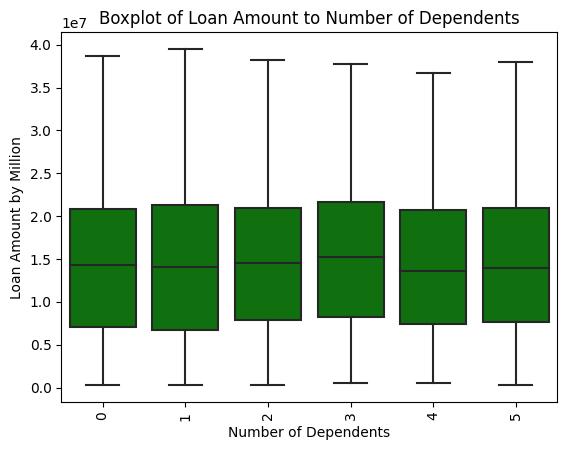

In [33]:
# Create boxplots for loan amount considering number of dependents
sns.boxplot(data = loan_df, x = 'no_of_dependents', y = 'loan_amount', color = "green")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Number of Dependents")
plt.xlabel("Number of Dependents")
plt.ylabel("Loan Amount by Million")
plt.show()

Eduction Level

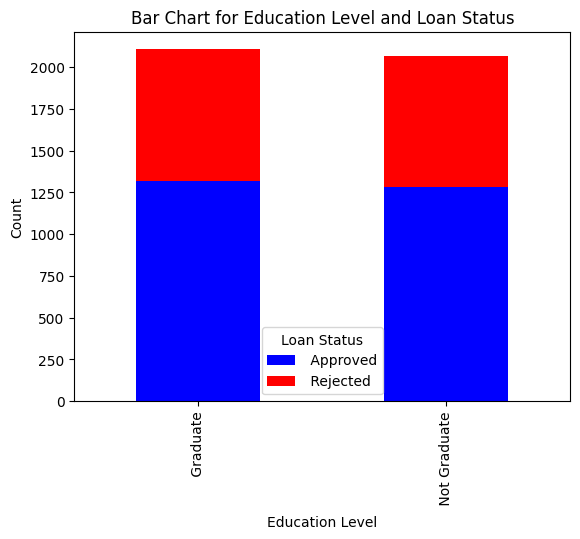

In [34]:
# Create a crosstab for education level and loan status
dependent_crosstab = pd.crosstab(loan_df["education"], loan_df["loan_status"])

# Display the bar chart
dependent_crosstab.plot(kind = "bar", stacked = True, color = ["blue", "red"])
plt.legend(title = "Loan Status")
plt.title("Bar Chart for Education Level and Loan Status")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

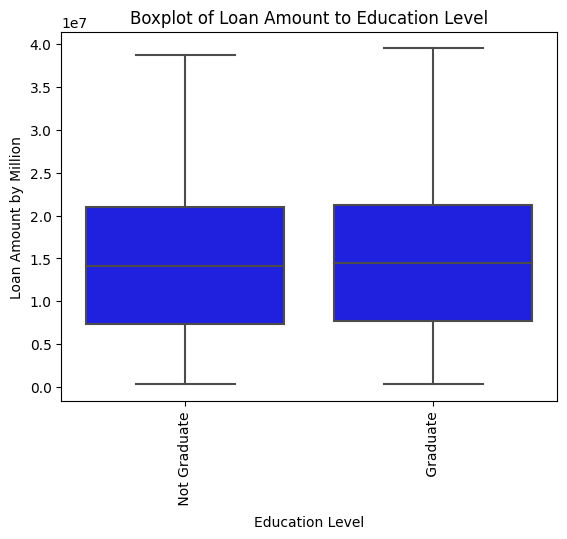

In [35]:
# Create boxplots for loan amount considering education level
sns.boxplot(data = loan_df, x = 'education', y = 'loan_amount', color = "blue")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Education Level")
plt.xlabel("Education Level")
plt.ylabel("Loan Amount by Million")
plt.show()

Self Employment Status

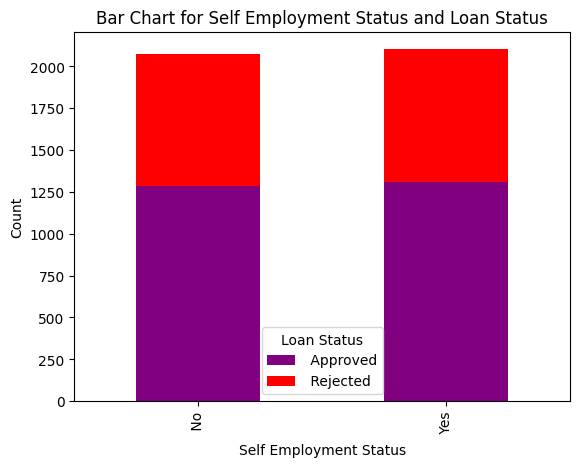

In [36]:
# Create a crosstab for self employment status and loan status
dependent_crosstab = pd.crosstab(loan_df["self_employed"], loan_df["loan_status"])

# Create a bar chart
dependent_crosstab.plot(kind = "bar", stacked = True, color = ["purple", "red"])
plt.legend(title = "Loan Status")
plt.title("Bar Chart for Self Employment Status and Loan Status")
plt.xlabel("Self Employment Status")
plt.ylabel("Count")
plt.show()

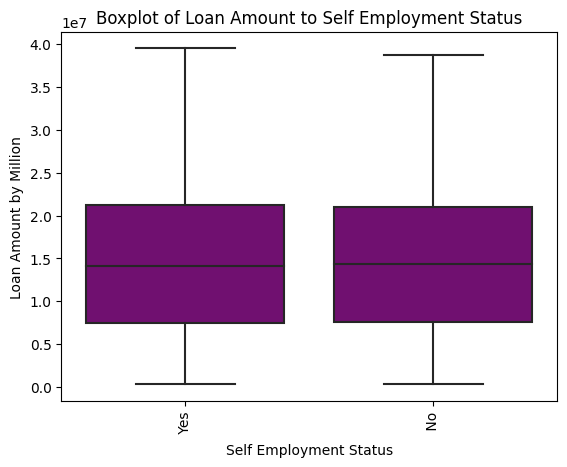

In [37]:
# Create boxplots for loan amount considering self employment status
sns.boxplot(data = loan_df, x = 'self_employed', y = 'loan_amount', color = "purple")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Self Employment Status")
plt.xlabel("Self Employment Status")
plt.ylabel("Loan Amount by Million")
plt.show()

Requested Loan Amount

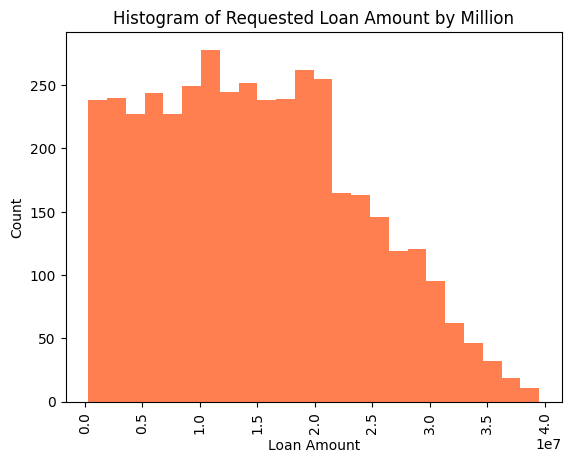

In [38]:
# Create a histogram for requested loan amount
plt.hist(data = loan_df, x = "loan_amount", bins = 'auto', color = "coral")
plt.xticks(rotation = 90)
plt.title("Histogram of Requested Loan Amount by Million")
plt.xlabel("Loan Amount")
plt.ylabel("Count")
plt.show()

Text(0, 0.5, 'Loan Amount by Million')

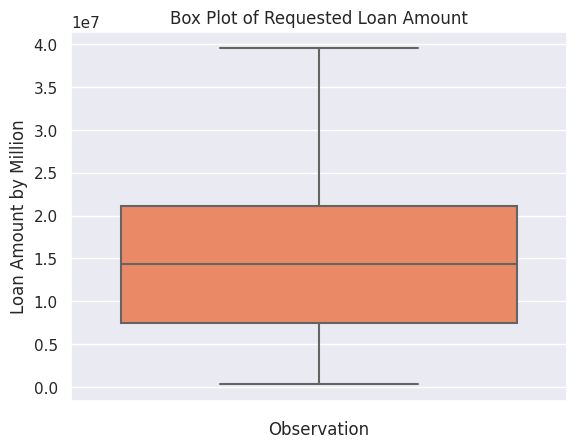

In [39]:
# Create a boxplot for total compensation with removed outliers
sns.set(style = 'darkgrid')
sns.boxplot(y = loan_df['loan_amount'], color = 'coral')
plt.title("Box Plot of Requested Loan Amount")
plt.xlabel("Observation")
plt.ylabel("Loan Amount by Million")

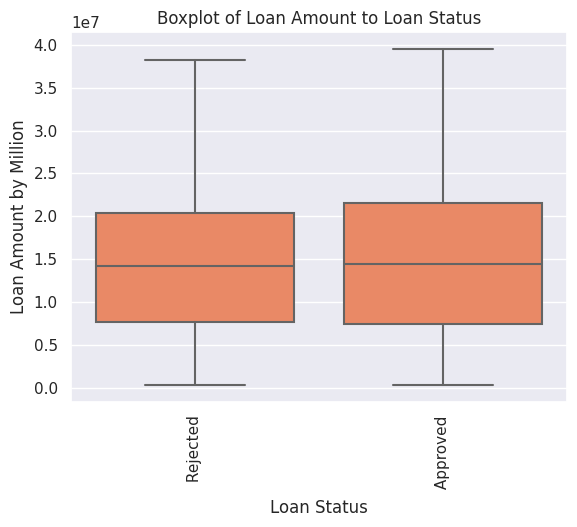

In [40]:
# Create boxplots for loan status considering loan amount
sns.boxplot(data = loan_df, x = 'loan_status', y = 'loan_amount', color = "coral")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Loan Amount by Million")
plt.show()

Annual Income

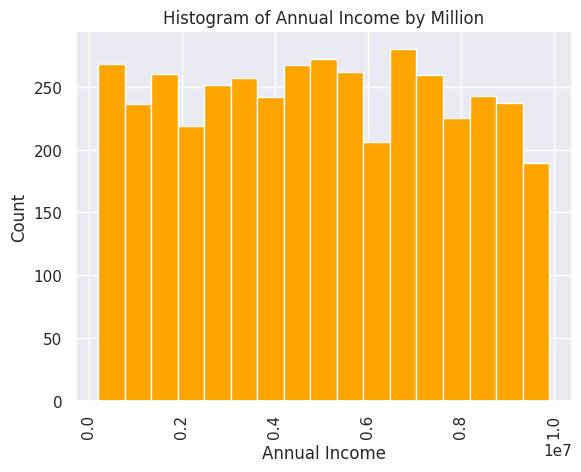

In [41]:
# Create a histogram for annual income
plt.hist(data = loan_df, x = "income_annum", bins = 'auto', color = "orange")
plt.xticks(rotation = 90)
plt.title("Histogram of Annual Income by Million")
plt.xlabel("Annual Income")
plt.ylabel("Count")
plt.show()

Text(0, 0.5, 'Total Compensation')

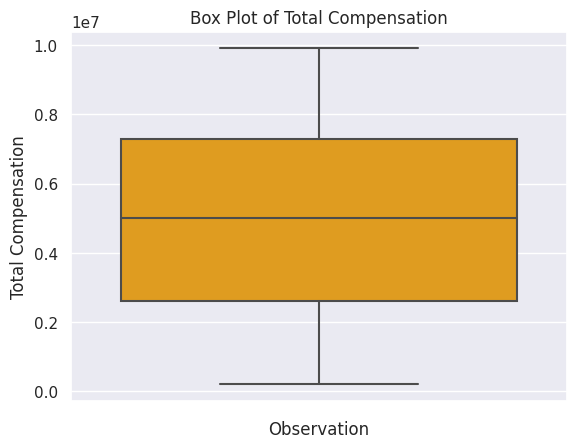

In [42]:
# Create a boxplot for total compensation
sns.set(style = 'darkgrid')
sns.boxplot(y = loan_df['income_annum'], color = 'orange')
plt.title("Box Plot of Total Compensation")
plt.xlabel("Observation")
plt.ylabel("Total Compensation")

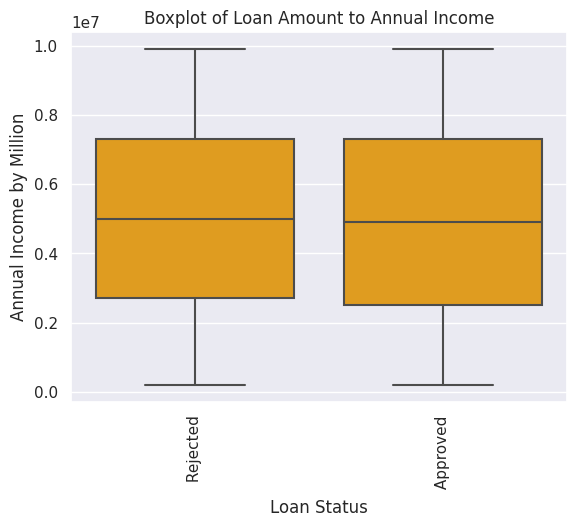

In [43]:
# Create boxplots for loan amount considering annual income
sns.boxplot(data = loan_df, x = 'loan_status', y = 'income_annum', color = "orange")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Annual Income")
plt.xlabel("Loan Status")
plt.ylabel("Annual Income by Million")
plt.show()

Loan Term

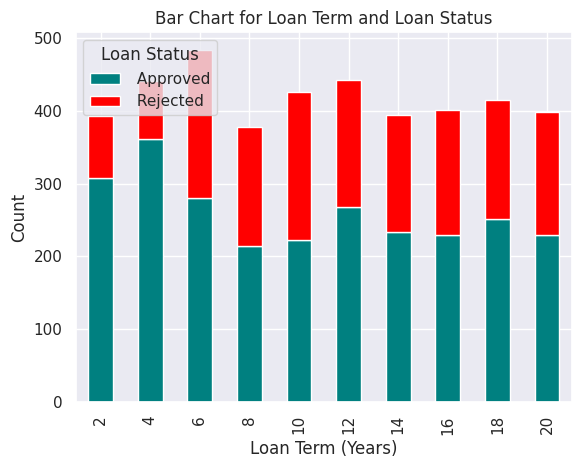

In [44]:
# Create a crosstab for self employment status and loan status
dependent_crosstab = pd.crosstab(loan_df["loan_term"], loan_df["loan_status"])

# Create a bar chart
dependent_crosstab.plot(kind = "bar", stacked = True, color = ["teal", "red"])
plt.legend(title = "Loan Status")
plt.title("Bar Chart for Loan Term and Loan Status")
plt.xlabel("Loan Term (Years)")
plt.ylabel("Count")
plt.show()

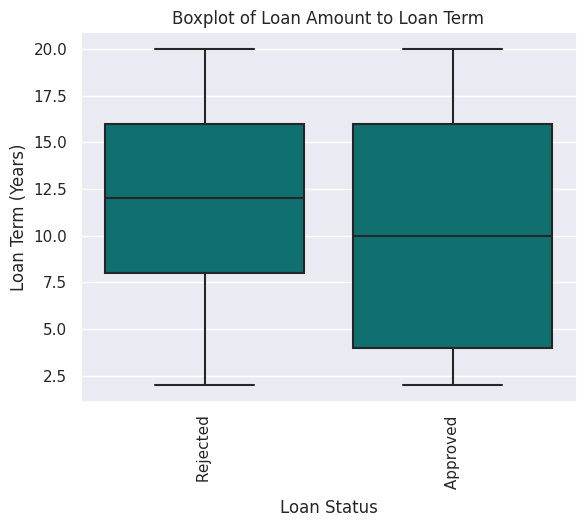

In [45]:
# Create boxplots for loan amount considering loan term
sns.boxplot(data = loan_df, x = 'loan_status', y = 'loan_term', color = "teal")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Loan Term")
plt.xlabel("Loan Status")
plt.ylabel("Loan Term (Years)")
plt.show()

Cibil Scores

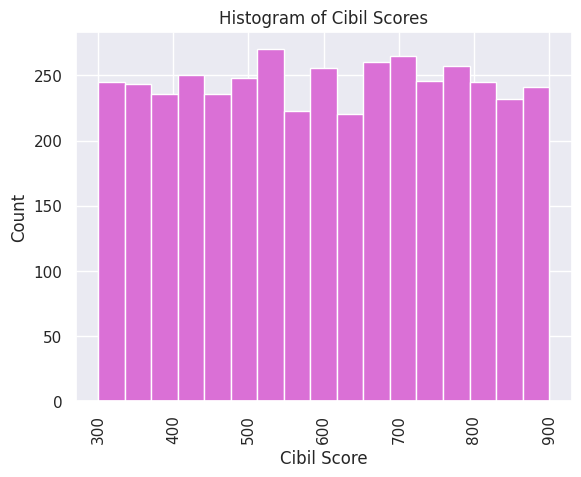

In [46]:
# Create a histogram for cibil scores
plt.hist(data = loan_df, x = "cibil_score", bins = 'auto', color = "orchid")
plt.xticks(rotation = 90)
plt.title("Histogram of Cibil Scores")
plt.xlabel("Cibil Score")
plt.ylabel("Count")
plt.show()

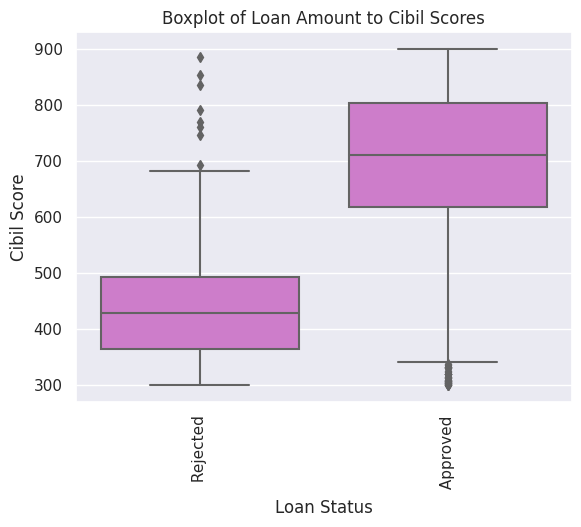

In [47]:
# Create boxplots for loan status considering cibil scores
sns.boxplot(data = loan_df, x = 'loan_status', y = 'cibil_score', color = "orchid")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Cibil Scores")
plt.xlabel("Loan Status")
plt.ylabel("Cibil Score")
plt.show()

Residential Asset Values

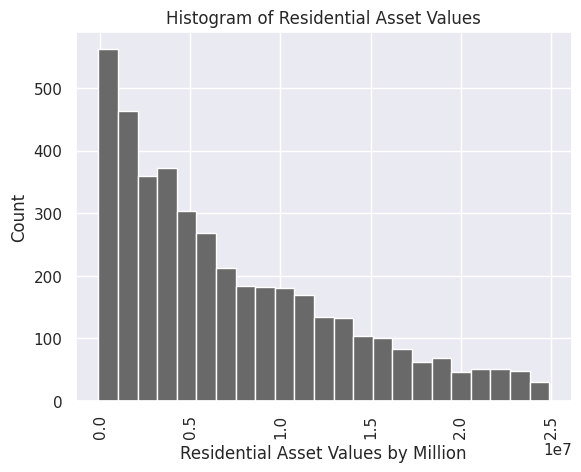

In [48]:
# Create a histogram for residential asset values
plt.hist(data = loan_df, x = "residential_assets_value", bins = 'auto', color = "dimgrey")
plt.xticks(rotation = 90)
plt.title("Histogram of Residential Asset Values")
plt.xlabel("Residential Asset Values by Million")
plt.ylabel("Count")
plt.show()

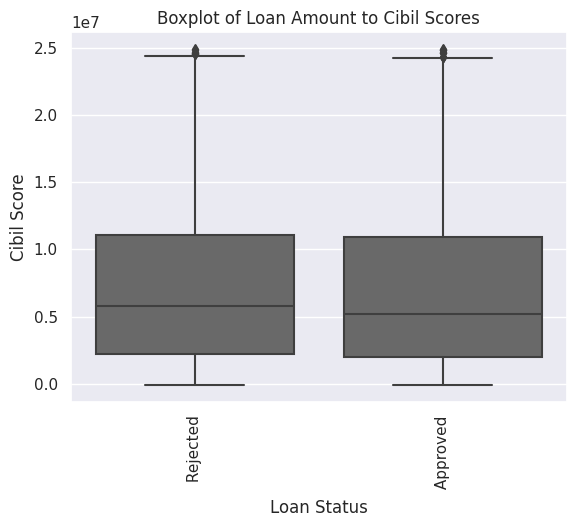

In [49]:
# Create boxplots for loan status considering cibil scores
sns.boxplot(data = loan_df, x = 'loan_status', y = 'residential_assets_value', color = "dimgrey")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Cibil Scores")
plt.xlabel("Loan Status")
plt.ylabel("Cibil Score")
plt.show()

Commerical Asset Values

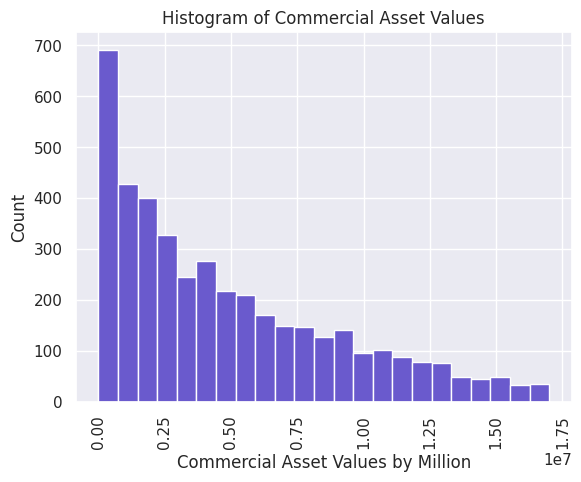

In [50]:
# Create a histogram for commercial asset values
plt.hist(data=loan_df, x="commercial_assets_value", bins="auto", color="slateblue")
plt.xticks(rotation=90)
plt.title("Histogram of Commercial Asset Values")
plt.xlabel("Commercial Asset Values by Million")
plt.ylabel("Count")
plt.show()

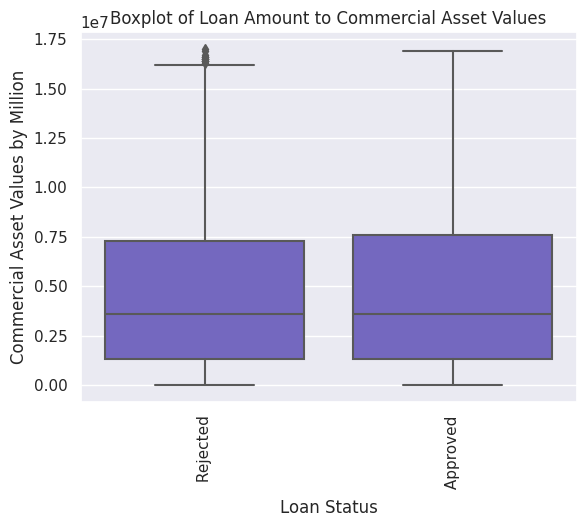

In [51]:
# Create boxplots for loan status considering commercial asset values
sns.boxplot(data = loan_df, x = 'loan_status', y = 'commercial_assets_value', color = "slateblue")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Commercial Asset Values")
plt.xlabel("Loan Status")
plt.ylabel("Commercial Asset Values by Million")
plt.show()

Luxury Asset Values

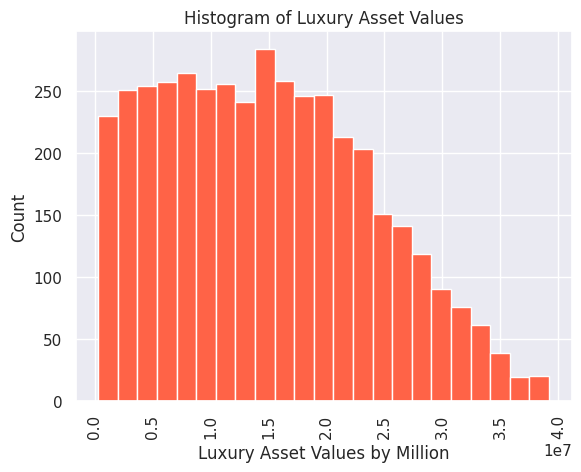

In [52]:
# Create a histogram for luxury asset values
plt.hist(data=loan_df, x="luxury_assets_value", bins="auto", color="tomato")
plt.xticks(rotation=90)
plt.title("Histogram of Luxury Asset Values")
plt.xlabel("Luxury Asset Values by Million")
plt.ylabel("Count")
plt.show()

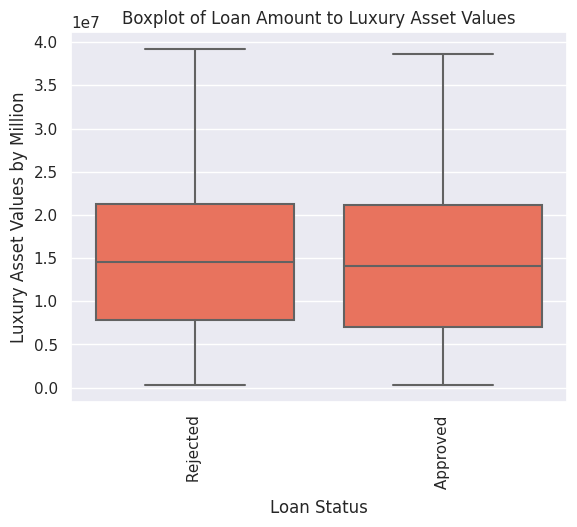

In [53]:
# Create boxplots for loan status considering luxury asset values
sns.boxplot(data = loan_df, x = 'loan_status', y = 'luxury_assets_value', color = "tomato")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Luxury Asset Values")
plt.xlabel("Loan Status")
plt.ylabel("Luxury Asset Values by Million")
plt.show()

Bank Asset Values

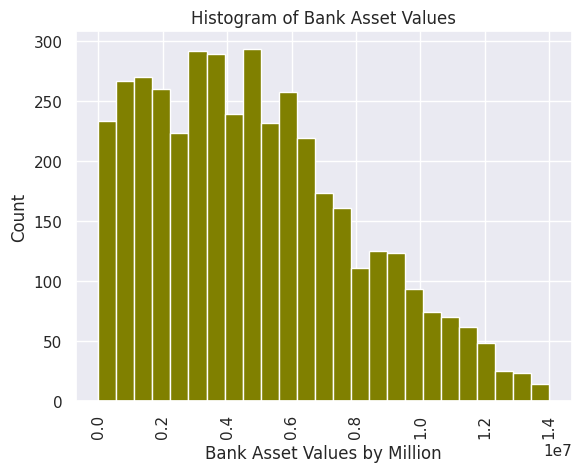

In [54]:
# Create a histogram for bank asset values
plt.hist(data=loan_df, x="bank_asset_value", bins="auto", color="olive")
plt.xticks(rotation=90)
plt.title("Histogram of Bank Asset Values")
plt.xlabel("Bank Asset Values by Million")
plt.ylabel("Count")
plt.show()

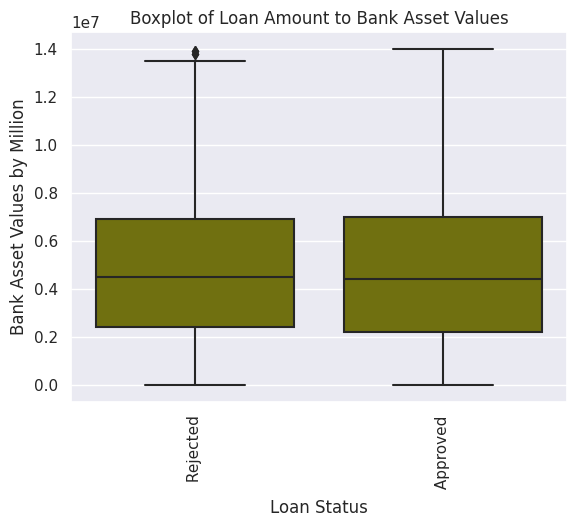

In [55]:
# Create boxplots for loan status considering luxury asset values
sns.boxplot(data = loan_df, x = 'loan_status', y = 'bank_asset_value', color = "olive")
plt.xticks(rotation = 90)
plt.title("Boxplot of Loan Amount to Bank Asset Values")
plt.xlabel("Loan Status")
plt.ylabel("Bank Asset Values by Million")
plt.show()

Create a correlation matrix with all numerical attributes



In [56]:
# Create a correlation matrix with each atttribute
loan_df.corr(method='pearson')

<ipython-input-56-59eae6e17058>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_df.corr(method='pearson')


,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
loan_id,1.000000,0.005884,0.013405,0.009556,0.005336,0.015991,0.023938,0.022695,0.001085,0.012257
no_of_dependents,0.005884,1.000000,0.008328,-0.005251,-0.020783,-0.010017,0.012032,-0.002042,0.003861,0.010527
income_annum,0.013405,0.008328,1.000000,0.927962,0.006938,-0.020922,0.627126,0.635076,0.929990,0.850779
loan_amount,0.009556,-0.005251,0.927962,1.000000,0.004848,-0.015739,0.591447,0.597812,0.863382,0.789859
loan_term,0.005336,-0.020783,0.006938,0.004848,1.000000,0.007863,0.002757,-0.011204,0.006588,0.013912
cibil_score,0.015991,-0.010017,-0.020922,-0.015739,0.007863,1.000000,-0.024220,0.005425,-0.025267,-0.017949
residential_assets_value,0.023938,0.012032,0.627126,0.591447,0.002757,-0.024220,1.000000,0.411741,0.586361,0.520692
commercial_assets_value,0.022695,-0.002042,0.635076,0.597812,-0.011204,0.005425,0.411741,1.000000,0.589048,0.548715
luxury_assets_value,0.001085,0.003861,0.929990,0.863382,0.006588,-0.025267,0.586361,0.589048,1.000000,0.788035
bank_asset_value,0.012257,0.010527,0.850779,0.789859,0.013912,-0.017949,0.520692,0.548715,0.788035,1.000000


In [57]:
loan_df.count()

loan_id                     4173
no_of_dependents            4173
education                   4173
self_employed               4173
income_annum                4173
loan_amount                 4173
loan_term                   4173
cibil_score                 4173
residential_assets_value    4173
commercial_assets_value     4173
luxury_assets_value         4173
bank_asset_value            4173
loan_status                 4173
dtype: int64

Chi-Squared Statistics

In [60]:
# Get the categorical columns
categorical_cols = ['education', 'self_employed', 'loan_term']
p_values = []

# Create contingency tables
for categorical_attr in categorical_cols:
    contingency_table = pd.crosstab(loan_df[categorical_attr], loan_df['loan_status'])

    # Get p-values from the contingency table
    chi2, p, degrees_of_freedom, expected_freq = chi2_contingency(contingency_table)
    p_values.append(p)

# Print the p-values for the categorical variables
p_values

[0.8054748482812306, 0.8808544370188185, 7.685890181657574e-29]

In [73]:
# Set the significance level
alpha = 0.05

# Get the Bonferroni-corrected significance level
adjusted_alpha = alpha / len(categorical_cols)

# Get attributes with a significance level less than 0.05
significant_attributes = [(categorical_attr, p) for categorical_attr, p in zip(categorical_cols, p_values) if p < adjusted_alpha]

# Print the statistically significant categorical values
print("Statistically Significant Attributes:")
for attribute, p_val in significant_attributes:
  print(f"{attribute}'s p-value = {p_val}")

Statistically Significant Attributes:
loan_term's p-value = 7.685890181657574e-29


T-Test for Numerical Variables

In [68]:
# Get the numerical values
numerical_vals = ["no_of_dependents", "income_annum", "loan_amount", "loan_term", "cibil_score",
                  "residential_assets_value", "commercial_assets_value", "luxury_assets_value", "bank_asset_value"]

p_vals = {}

# iterate through numeric columns and find statistical significance
for attribute in numerical_vals:
  uncanceled = loan_df[loan_df['loan_status'] == 0][attribute]
  canceled = loan_df[loan_df['loan_status'] == 1][attribute]

  # Perfrom a t-test for the numerical column
  t_stat, p_val = stats.ttest_ind(uncanceled, canceled)
  if p_val < alpha:
    p_vals[attribute] = p_val
    print(f"{attribute}'s p-value is: {p_val}")

# Edge case for no statistically significant p-values from the t-test
if not p_vals:
  print("No statistically significant p-values according to the t-test")

No statistically significant p-values according to the t-test


One-Way ANOVA for Numerical Variables

In [71]:
# Create an empty list to store results
anova_results = []

# iterate through numeric columns and find statistical significance
for attribute in numerical_vals:
  uncanceled = loan_df[loan_df['loan_status'] == 0][attribute]
  canceled = loan_df[loan_df['loan_status'] == 1][attribute]

  # Perform one-way ANOVA
  f_statistic, p_val = stats.f_oneway(uncanceled, canceled)

  # Determine statistical significance
  if p_val < alpha:
    print(f"{attribute}'s p-value is: {p_val}")

# Edge case for no statistically significant p-values from one-way ANOVA
if not anova_results:
  print("No statistically significant p-values according to the one-way ANOVA test")

No statistically significant p-values according to the one-way ANOVA test
